In [1]:
import glob

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

from tg import get_data_path, get_root_path
from tg.datasets import DATASET_FACTORY_LOOKUP

color_palette = list(sns.color_palette("husl", 9).as_hex())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
dict_dataset_names = {
    "AIR_PASSENGERS": "Passageiros aéreos",
    "HOMICIDES": 'Homicídios dolosos no RJ',
    "NOISY_SINE30": "Seno ruidoso",
    "PERFECT_SINE30": "Seno perfeito",
    "RANDOM_WALK": "Caminhada aleatória"
}

dict_column_names = {
    "params.model_name": "Modelo",
    "metrics.rmse": "RMSE",
    "metrics.mae": "MAE",
    "metrics.mape": "MAPE",
    "metrics.smape": "sMAPE",
    "params.dataset_name": "Conjunto de dados"
}


In [3]:
mlflow.set_tracking_uri("file:///{}".format(get_root_path("mlruns")))
experiment = mlflow.get_experiment('0')

In [4]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs['artifact_uri'] = runs['artifact_uri'].apply(lambda x: x.replace(
    x.split('mlruns')[0], 'file///{}'.format(get_root_path(""))).replace(
        '\\', '/'))
runs.head(3)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mape,metrics.smape,metrics.rmse,metrics.mae,params.dataset_name,params.n_train_points,params.params,params.model_name,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,e0fbcbb056f143a3b52350af2c383796,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-11-01 19:24:16.523000+00:00,2022-11-01 19:43:44.586000+00:00,7.246992,3.609720,36.234831,28.620689,HOMICIDES,110,"{'batch_size': 160, 'damped_trend': False, 'dr...",ES_LSTM,b0da01895fd37abca3109705dd2dc2d238fc3f79,.\src\tg\main.py,LOCAL,thundering-crow-864,Rafa
1,d4241a074eef4648b5a8dbc5ec8750c2,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-11-01 19:24:16.365000+00:00,2022-11-01 19:33:12.476000+00:00,11.081279,5.248543,0.198042,0.161335,NOISY_SINE30,110,"{'batch_size': 190, 'damped_trend': True, 'dro...",ES_LSTM,b0da01895fd37abca3109705dd2dc2d238fc3f79,.\src\tg\main.py,LOCAL,lyrical-grub-683,Rafa
2,598e245e950d44ffb724f79b1486a873,0,FINISHED,file///C:/Users/Rafa/Documents/Github/tg/mlrun...,2022-11-01 19:24:16.335000+00:00,2022-11-01 19:41:32.460000+00:00,2.107839,1.045156,0.023998,0.020282,RANDOM_WALK,110,"{'batch_size': 30, 'damped_trend': True, 'drop...",ES_LSTM,b0da01895fd37abca3109705dd2dc2d238fc3f79,.\src\tg\main.py,LOCAL,silent-smelt-831,Rafa


In [5]:
metrics_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name"
]].copy()

metrics_table = metrics_table.rename(columns=dict_column_names)

columns_order = ["Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE"]

metrics_table["Conjunto de dados"] = metrics_table[
    "Conjunto de dados"].replace(dict_dataset_names)

metrics_table = metrics_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True)

np.round(metrics_table, 4).head(3)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória


In [6]:
# _metrics_table = metrics_table[columns_order].round(1).set_index(
#     ["Conjunto de dados", "Modelo"])
# latex_metrics_table = _metrics_table.to_latex()
# print(latex_metrics_table)

In [7]:
preds = []
for _, row in runs[[
        "params.model_name", "params.dataset_name", "artifact_uri"
]].iterrows():
    model = row["params.model_name"]
    dataset = row["params.dataset_name"]
    artifact_uri = row["artifact_uri"].split("///")[-1]
    glob_pattern = f"{artifact_uri}/*.csv"
    aux = glob.glob(glob_pattern)
    if len(aux) > 0:
        path = aux[0]
        preds.append(pd.read_csv(path).iloc[:, 1].values)
    else:
        preds.append(np.nan)

runs["Predições"] = preds

In [8]:
preds_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name", "Predições"
]].copy()

preds_table = preds_table.rename(columns=dict_column_names)
columns_order = [
    "Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE", "Predições"
]

preds_table["Conjunto de dados"] = preds_table["Conjunto de dados"].replace(
    dict_dataset_names)

preds_table = preds_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True).dropna()

np.round(preds_table, 4)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados,Predições
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória,"[1.4545454542745244, 1.3727272735400635, 1.309..."
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,"[1.4545454545454657, 1.37272725877498, 1.30909..."
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,"[1.4545454545454657, 1.37272725877498, 1.30909..."
3,ELM,0.0116,0.9051,0.4517,0.0088,Caminhada aleatória,"[1.4598205817363, 1.380376889158171, 1.3165024..."
4,SARIMA_SVR,0.0115,0.9245,0.4618,0.0088,Caminhada aleatória,"[1.4551772004858463, 1.3788419538323151, 1.308..."
5,STL_ELM,0.0127,1.0729,0.5379,0.0105,Caminhada aleatória,"[1.463540809985827, 1.3851957044445846, 1.3179..."
6,SVR,0.0127,1.0839,0.5398,0.0105,Caminhada aleatória,"[1.461173849771065, 1.3901276134555207, 1.3172..."
7,ARIMA_RNN,0.0146,1.1950,0.5979,0.0117,Caminhada aleatória,"[1.4483178, 1.3878971, 1.3466333, 1.2407963, 1..."
8,RNN,0.0258,1.8571,0.9171,0.0187,Caminhada aleatória,"[1.4620461, 1.4327053, 1.311759, 1.2662796, 1...."
9,ES_LSTM,0.0240,2.1078,1.0452,0.0203,Caminhada aleatória,"[1.4734713, 1.3998998, 1.3218347, 1.2732835, 1..."


In [9]:
HYBRID_MODELS = ["ARIMA_RNN", "SARIMA_SVR", "STL_ELM", "ES_LSTM"]
model_names = HYBRID_MODELS
ALL_MODELS = [
    'NAIVE', 'ARIMA', 'SARIMA', 'RNN', 'SVR', 'ELM', 'STL', 'ES', 'LSTM',
    'ARIMA_RNN', 'SARIMA_SVR', 'STL_ELM', 'ES_LSTM'
]


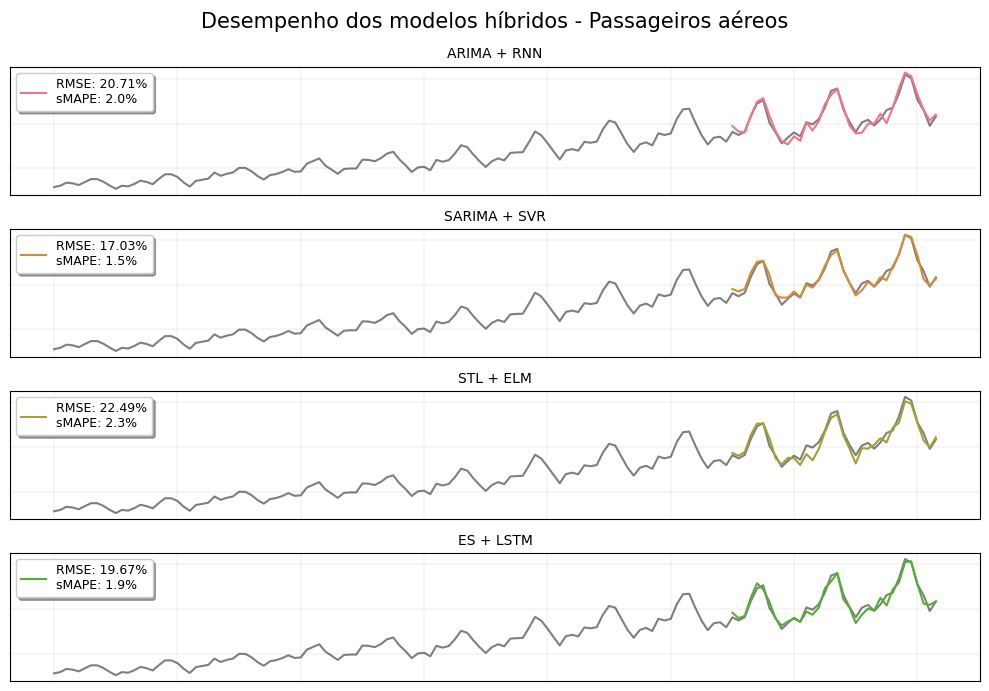

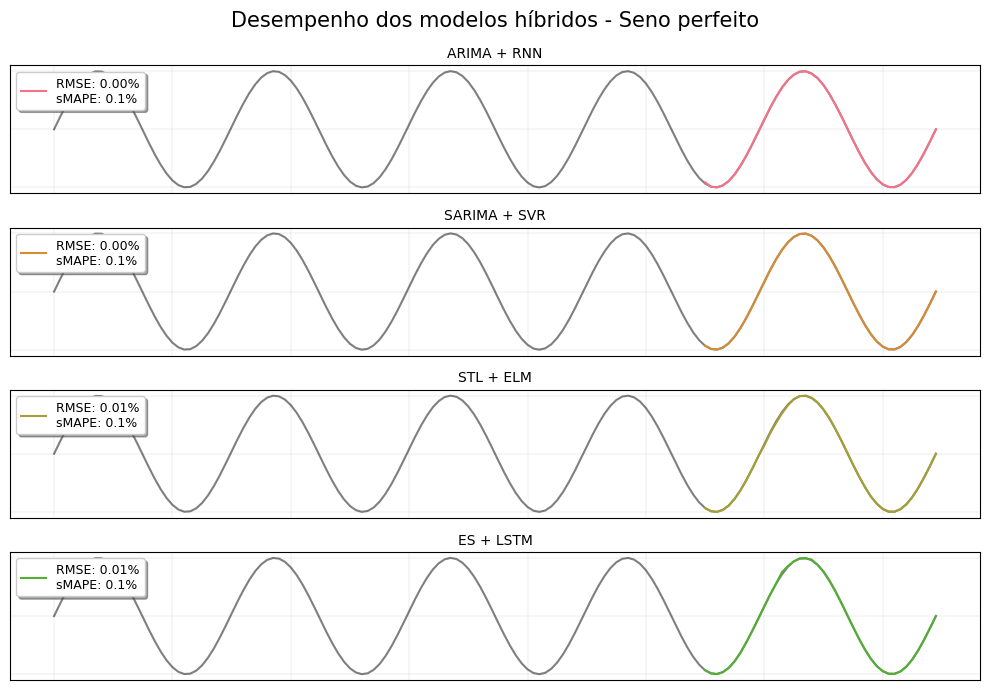

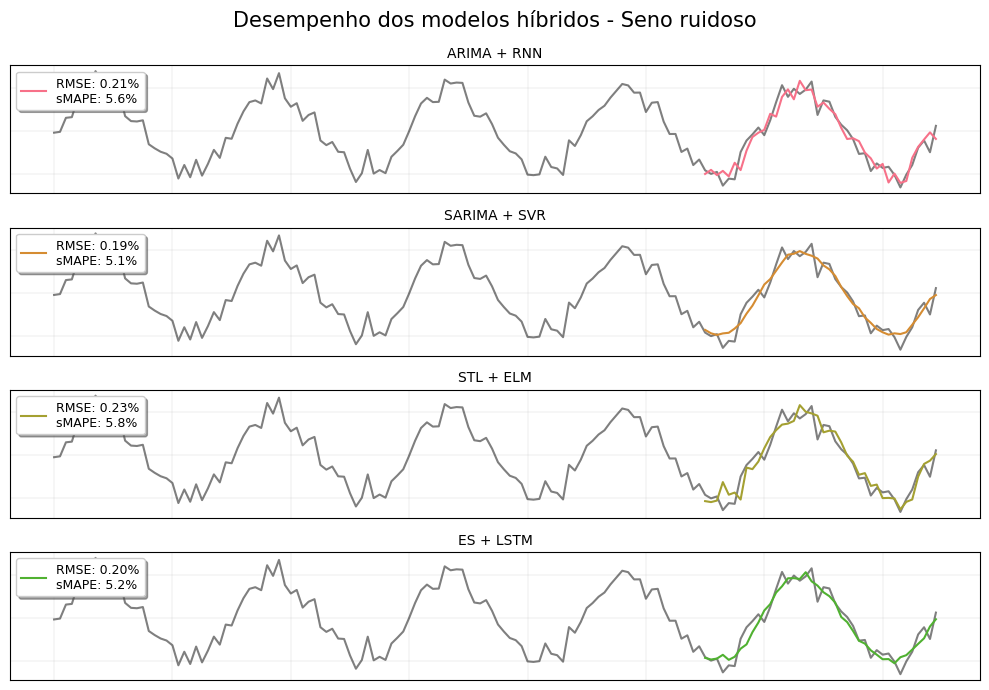

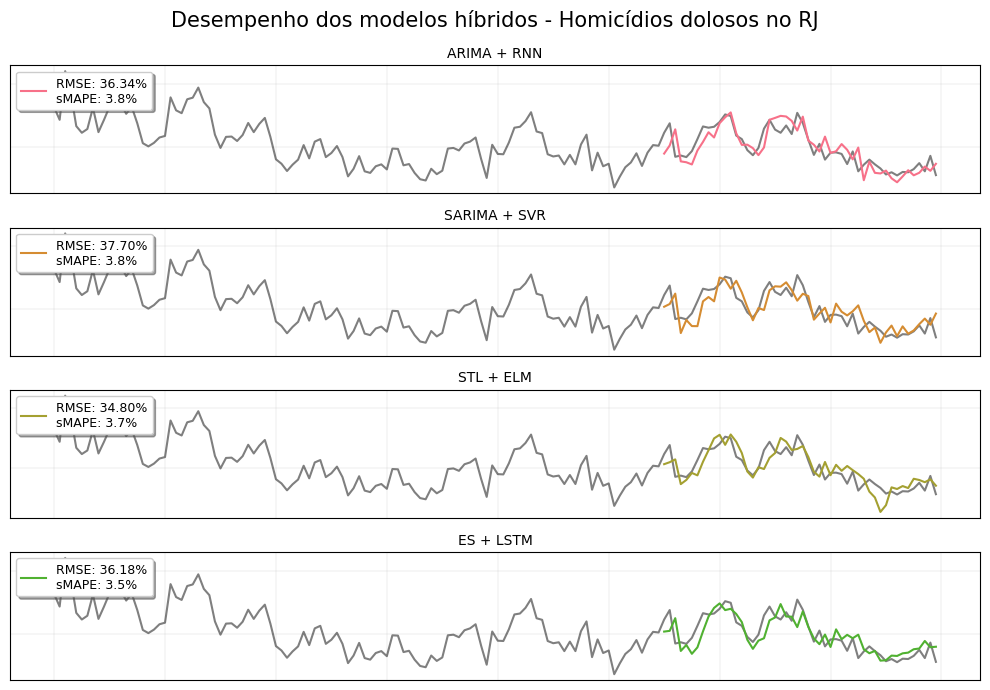

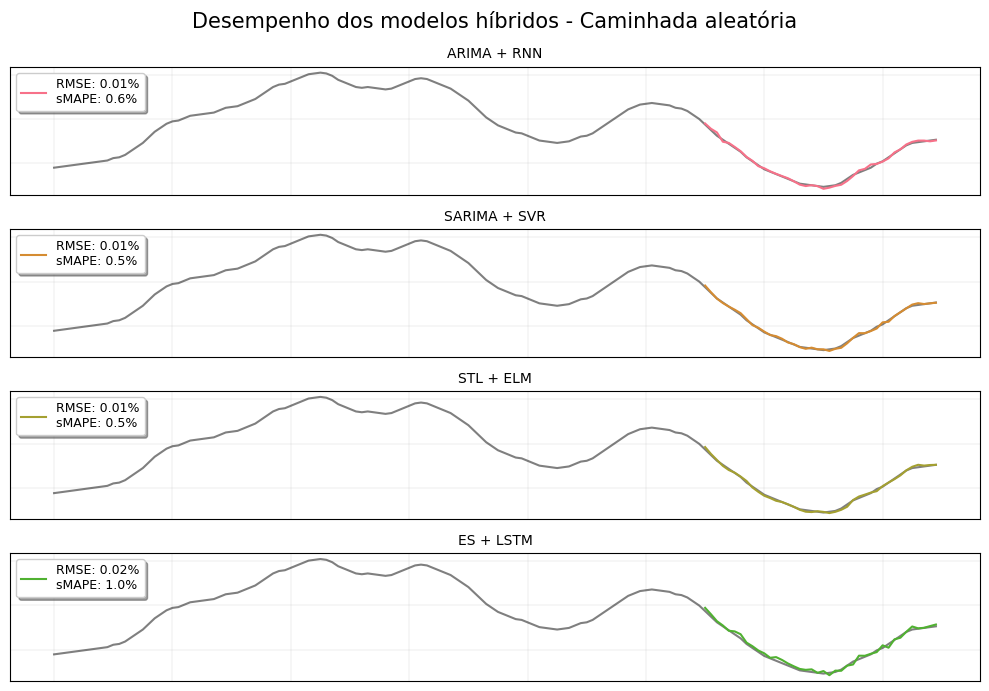

In [10]:
for dataset_name in DATASET_FACTORY_LOOKUP.keys():

    series = DATASET_FACTORY_LOOKUP[dataset_name]()

    fig, axs = plt.subplots(4, 1, figsize=(10, 7))

    for i, model in enumerate(model_names):

        aux_data = preds_table.loc[(preds_table['Modelo'] == model) &
                                   (preds_table['Conjunto de dados'] ==
                                    dict_dataset_names[dataset_name]), :]
        aux_pred = aux_data['Predições'].values[0]
        aux_model = ' + '.join(model.split('_')).upper()

        axs[i].set_title(aux_model, fontsize=10)
        axs[i].plot(range(len(series)), series, color='black', alpha=0.5)
        axs[i].plot(range(len(series) - len(aux_pred), len(series)),
                    aux_pred,
                    color=color_palette[i],
                    label="RMSE: {:.2f}%\nsMAPE: {:.1f}%".format(
                        aux_data['RMSE'].values[0],
                        aux_data['sMAPE'].values[0]))

    for ax in axs:

        for tick in ax.xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        for tick in ax.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.legend(fontsize=9, shadow=True, loc='upper left')
        ax.grid(linewidth=0.15)

    fig.suptitle("Desempenho dos modelos híbridos - {}".format(
        dict_dataset_names[dataset_name]),
                 fontsize=15)
    plt.tight_layout()
    plt.savefig(get_root_path("reports/desempenho_hibridos_{}.png".format(
        dataset_name.lower())),
                dpi=300)
    plt.show()

In [11]:
preds_table.loc[preds_table['Modelo'].isin(HYBRID_MODELS),
                'Tipo dos modelos'] = 'Híbridos'
preds_table.loc[~preds_table['Modelo'].isin(HYBRID_MODELS + ['NAIVE']),
                'Tipo dos modelos'] = 'Não híbridos'


In [12]:
modeltype_comparing_table = preds_table.groupby(
    ['Conjunto de dados', 'Tipo dos modelos']).agg(['mean', 'median']).round(4)
modeltype_comparing_table

C:\Users\Rafa\AppData\Local\Temp\ipykernel_42700\690679148.py:1: FutureWarning: ['Modelo', 'Predições'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  modeltype_comparing_table = preds_table.groupby(


RMSE              MAPE           \
                                              mean   median     mean   median   
Conjunto de dados        Tipo dos modelos                                       
Caminhada aleatória      Híbridos           0.0157   0.0137   1.3251   1.1340   
                         Não híbridos       0.0230   0.0121   1.8666   0.9945   
Homicídios dolosos no RJ Híbridos          36.2552  36.2585   7.3946   7.4264   
                         Não híbridos      35.4851  36.0305   7.2047   7.2246   
Passageiros aéreos       Híbridos          19.9742  20.1904   3.7887   3.8059   
                         Não híbridos      22.7001  20.9429   4.2882   3.9119   
Seno perfeito            Híbridos           0.0053   0.0055   0.1717   0.1594   
                         Não híbridos       0.0312   0.0140   1.5914   0.2331   
Seno ruidoso             Híbridos           0.2078   0.2050  11.4732  11.3257   
                         Não híbridos       0.2256   0.2316  12.4142  12.7150   

                                            sMAPE              MAE           
                                             mean  median     mean   median  
Conjunto de dados        Tipo dos modelos                                    
Caminhada aleatória      Híbridos          0.6607  0.5679   0.0128   0.0111  
                         Não híbridos      0.9192  0.4958   0.0183   0.0096  
Homicídios dolosos no RJ Híbridos          3.6903  3.7185  29.0418  29.0113  
                         Não híbridos      3.5789  3.6176  28.4029  28.3548  
Passageiros aéreos       Híbridos          1.9125  1.9201  15.9077  16.0727  
                         Não híbridos      2.1430  1.9319  18.1786  16.1919  
Seno perfeito            Híbridos          0.0858  0.0796   0.0030   0.0029  
                         Não híbridos      0.7627  0.1170   0.0250   0.0043  
Seno ruidoso             Híbridos          5.4407  5.4342   0.1671   0.1666  
                         Não híbridos      5.8533  5.9498   0.1791   0.1827

In [13]:
dataset_name = "Passageiros aéreos"

df_aux = pd.DataFrame()
for dataset_name in np.unique([x[0] for x in modeltype_comparing_table.index]):
    aux = modeltype_comparing_table.loc[dataset_name]
    df_aux = pd.concat([
        df_aux,
        pd.DataFrame(100 * np.round(
            (aux.iloc[1, :] - aux.iloc[0, :]) / aux.iloc[1, :], 3),
                     columns=[dataset_name])
    ],
                       axis=1)

df_aux

Caminhada aleatória  Homicídios dolosos no RJ  \
RMSE  mean                   31.7                      -2.2   
      median                -13.2                      -0.6   
MAPE  mean                   29.0                      -2.6   
      median                -14.0                      -2.8   
sMAPE mean                   28.1                      -3.1   
      median                -14.5                      -2.8   
MAE   mean                   30.1                      -2.2   
      median                -15.6                      -2.3   

              Passageiros aéreos  Seno perfeito  Seno ruidoso  
RMSE  mean                  12.0           83.0           7.9  
      median                 3.6           60.7          11.5  
MAPE  mean                  11.6           89.2           7.6  
      median                 2.7           31.6          10.9  
sMAPE mean                  10.8           88.8           7.0  
      median                 0.6           32.0           8.7  
MAE   mean                  12.5           88.0           6.7  
      median                 0.7           32.6           8.8

In [14]:
df_aux.mean(axis=1)

RMSE   mean      26.48
       median    12.40
MAPE   mean      26.96
       median     5.68
sMAPE  mean      26.32
       median     4.80
MAE    mean      27.02
       median     4.84
dtype: float64